In [1]:
import os
import csv
import cv2
import json
import yaml
import numpy as np
import shutil
from random import seed, shuffle
from pathlib import Path
from itertools import product
from scipy.spatial.distance import euclidean

In [2]:
def ensure_path(path: str) -> Path:
    path = Path(path)
    if not os.path.exists(path):
        os.makedirs(path)
    return path

class Tiler():
    def __init__(self, w=8192, h=5460, dw=512, dh=546, stride=1):
        self.w = w
        self.h = h
        self.dw = dw
        self.dh = dh
        self.stride = stride
        self.offset = (self.dw*self.stride, self.dh*self.stride)
        self.cols = int(np.ceil(self.w / self.offset[0]))
        self.rows = int(np.ceil(self.h / self.offset[1]))
        
    def get_tile_dict(self):
        
        tile_dict = {}
        for col, row in product(range(self.cols), range(self.rows)):
            top = int(self.offset[1]*row)
            bottom = top + self.dh
            left = int(self.offset[0]*col)
            right = left + self.dw
            
            tile_dict[(col,row)] = (top, bottom, left, right)
        return tile_dict
    
    def get_tile_id_from_point(self, tile_dict, point):
        step = int(1/self.stride)
        x = point['x']
        y = point['y']
        
        id_x1 = int(np.floor(x/self.offset[0]))
        id_x1 = id_x1 if not id_x1 == self.cols else self.cols-1
        id_y1 = int(np.floor(y/self.offset[1]))
        id_y1 = id_y1 if not id_y1 == self.rows else self.rows-1
        id_1 = (id_x1, id_y1)
        
        return id_1
            
        
        
#         id_x2 = int(np.ceil(x/self.offset[0]))
#         id_x2 = id_x2 if not id_x2 == self.cols else self.cols-1
#         id_y2 = int(np.floor(y/self.offset[1]))
#         id_y2 = id_y2 if not id_y2 == self.rows else self.rows-1
#         id_2 = (id_x2-step, id_y2) if id_x2 >= step else (0, id_y2)
        
#         id_x3 = int(np.floor(x/self.offset[0]))
#         id_x3 = id_x3 if not id_x3 == self.cols else self.cols-1
#         id_y3 = int(np.ceil(y/self.offset[1]))
#         id_y3 = id_y3 if not id_y3 == self.rows else self.rows-1
#         id_3 = (id_x3, id_y3-step) if id_y3 >= step else (id_x3, 0)
        
#         id_x4 = int(np.ceil(x/self.offset[0]))
#         id_x4 = id_x4 if not id_x4 == self.cols else self.cols-1
#         id_y4 = int(np.ceil(y/self.offset[1]))
#         id_y4 = id_y4 if not id_y4 == self.rows else self.rows-1
        
#         if id_x4 >= step:
#             if id_y4 >= step:
#                 id_4 = (id_x4-step, id_y4-step)
#             else:
#                 id_4 = (id_x4-step, 0)
#         else:
#             if id_y4 >= step:
#                 id_4 = (0, id_y4-step)
#             else:
#                 id_4 = (0, 0)
        
#         id_set = set([id_1,id_2,id_3,id_4])
        
#         best_id = -1
#         min_dist = self.dh
#         for id in id_set:
#             t,b,l,r = tile_dict[id]
#             tile_center = (int((r+l)/2), int((b+t)/2))
#             d = euclidean(tile_center, (x,y))
#             if d < min_dist:
#                 min_dist = d
#                 best_id = id
        
#         return best_id

In [3]:
with open('../params.yaml', 'r') as params_file:
    params = yaml.safe_load(params_file)
    raw_dir = Path("../") / params['data']['raw_dir']

points_path = raw_dir / 'Points_25Nov_01_FINAL.pnt'
with open(points_path) as file:
    data = file.read()
    data = json.loads(data)
    points_dict = data.get('points')

In [4]:
tl = Tiler()
tile_dict = tl.get_tile_dict()

In [5]:
nonempty_tile_dict = {}
tile_count = 0
for img_id, coords_dict in points_dict.items():
    tile_list = []
    for _, pts in coords_dict.items():
        for pt in pts:
#             import ipdb; ipdb.set_trace()
            tile_id = tl.get_tile_id_from_point(tile_dict, pt)
            tile_list.append(tile_id)
    tile_set = set(tile_list)
    tile_count += len(tile_set)
    if tile_set:
        nonempty_tile_dict[img_id] = tile_set
print(tile_count)

2744


In [167]:
tile_root = Path("/media/polydatum/Seagate/dev/bird-counting/data/nonempty-slices/")
tile_folder = ensure_path(tile_root / 'trainvaltest')
for img_id, tile_set in nonempty_tile_dict.items():
    img = cv2.imread(str(raw_dir/img_id))
    for tile_id in tile_set:
        t,b,l,r = tile_dict[tile_id]
        tile = img[t:b,l:r]
        tilename = (os.path.splitext(img_id)[0] + f"_t{t:04d}_b{b:04d}_l{l:04d}_r{r:04d}.jpg")
        tilepath = str(Path(tile_folder) / tilename)
        cv2.imwrite(tilepath, tile)

In [6]:
nonempty_ids = list(nonempty_tile_dict.keys())
nonempty_ids = [int(os.path.splitext(id.split("_")[2])[0]) for id in nonempty_ids]
print(len(nonempty_ids))
seed(1)
shuffle(nonempty_ids)
hold_ids = nonempty_ids[:17]
rem_ids = nonempty_ids[17:]

117


In [172]:

files = os.listdir(tile_folder)
hold_folder = ensure_path(tile_root / 'holdout')
done_imgs = []
for file in files:
    img_id = int(os.path.splitext(file.split("_")[2])[0])
    if img_id in hold_ids:
        shutil.move(tile_folder / file,  hold_folder / file)

In [149]:
counts = {}

for file in files:
    img_id = int(os.path.splitext(file.split("_")[2])[0])
    original_filename = '_'.join(file.split('_')[:3]) + '.JPG'
    if counts.get(original_filename) is None:
        counts[original_filename] = 1
    else:
        counts[original_filename] += 1

for key in points_dict.keys():
    if key not in counts.keys():
        counts[key] = 0

with open('../per_image_count.csv', 'w') as csv_file:  
    writer = csv.writer(csv_file)
    for key, value in counts.items():
       writer.writerow([key, value])

{'DJI_20210928101619_0001.JPG': 72,
 'DJI_20210928101621_0002.JPG': 67,
 'DJI_20210928101623_0003.JPG': 54,
 'DJI_20210928101625_0004.JPG': 64,
 'DJI_20210928101627_0005.JPG': 95,
 'DJI_20210928101629_0006.JPG': 144,
 'DJI_20210928101631_0007.JPG': 83,
 'DJI_20210928101633_0008.JPG': 38,
 'DJI_20210928101635_0009.JPG': 56,
 'DJI_20210928101637_0010.JPG': 49,
 'DJI_20210928101639_0011.JPG': 37,
 'DJI_20210928101640_0012.JPG': 44,
 'DJI_20210928101641_0013.JPG': 37,
 'DJI_20210928101643_0014.JPG': 61,
 'DJI_20210928101645_0015.JPG': 57,
 'DJI_20210928101647_0016.JPG': 9,
 'DJI_20210928101649_0017.JPG': 2,
 'DJI_20210928101651_0018.JPG': 5,
 'DJI_20210928101652_0019.JPG': 1,
 'DJI_20210928101654_0020.JPG': 1,
 'DJI_20210928101656_0021.JPG': 47,
 'DJI_20210928101658_0022.JPG': 100,
 'DJI_20210928101700_0023.JPG': 30,
 'DJI_20210928101702_0024.JPG': 6,
 'DJI_20210928101704_0025.JPG': 27,
 'DJI_20210928101706_0026.JPG': 9,
 'DJI_20210928101708_0027.JPG': 21,
 'DJI_20210928101710_0028.JPG': 3

In [7]:
all_tile_dict = {}
tile_count = 0
for img_id, coords_dict in points_dict.items():
    tile_list = []
    tile_set = set(tile_dict.keys())
    tile_count += len(tile_set)
    all_tile_dict[img_id] = tile_set
print(tile_count)

32800


In [ ]:
from tqdm import tqdm
tile_root = Path("/media/polydatum/Seagate/dev/bird-counting/data/nonempty-slices/")
all_tile_folder = ensure_path(tile_root / 'all')
for img_id, tile_set in tqdm(all_tile_dict.items()):
#     import ipdb; ipdb.set_trace()
    img = cv2.imread(str(raw_dir/img_id))
    for tile_id in tile_set, leave=True:
        t,b,l,r = tile_dict[tile_id]
        tile = img[t:b,l:r]
        tilename = (os.path.splitext(img_id)[0] + f"_t{t:04d}_b{b:04d}_l{l:04d}_r{r:04d}.jpg")
        tilepath = str(Path(all_tile_folder) / tilename)
#         cv2.imwrite(tilepath, tile)

In [8]:
hold_ids

[201, 113, 109, 21, 137, 78, 5, 7, 34, 11, 15, 124, 40, 200, 190, 47, 37]

In [9]:
count_dict = {}
for img_id, data in points_dict.items():
    c1 = 0
    c2 = 0
    if data.get('Nesting'):
        c1 = len(data.get('Nesting'))
    if data.get('Flying'):
        c2 = len(data.get('Flying'))
    count_dict[img_id] = c1+c2

In [188]:
with open('../per_image_count.csv', 'w') as csv_file:  
    writer = csv.writer(csv_file)
    for key, value in count_dict.items():
       writer.writerow([key, value])

In [10]:
all_results = {}
with open('../results/new-model/all-inference-results.json', 'r') as f:
    data = f.readlines()
    for datum in data:
        temp = json.loads(datum.replace('\n',''))
        img_id = temp['image'].split('_')[2]
        if all_results.get(img_id):
            all_results[img_id] += len(temp['prediction'])
        else:
            all_results[img_id] = len(temp['prediction'])

In [39]:
hold_results = {}
for id in hold_ids:
    key = f"{id:04d}"
    value = all_results[f"{id:04d}"]
    hold_results[key] = value

In [40]:
all_preds = {}
for id in range(1,206):
    key = f"{id:04d}"
    value = all_results[f"{id:04d}"]
    all_preds[key] = value

In [41]:
hold_ids.sort()
hold_ids

[5, 7, 11, 15, 21, 34, 37, 40, 47, 78, 109, 113, 124, 137, 190, 200, 201]

In [42]:
xs = []
ys = []
for key, value in count_dict.items():
    img_id = os.path.splitext(key.split('_')[2])[0]
    if hold_results.get(img_id):
        xs.append(value)
        ys.append(hold_results[img_id])

In [43]:
xs, ys

([545, 470, 171, 263, 233, 1313, 1268, 195, 1, 1807, 1, 2094, 1, 3, 1, 3, 5],
 [412, 376, 136, 209, 197, 1102, 1079, 168, 22, 1016, 1, 1325, 1, 2, 3, 3, 1])

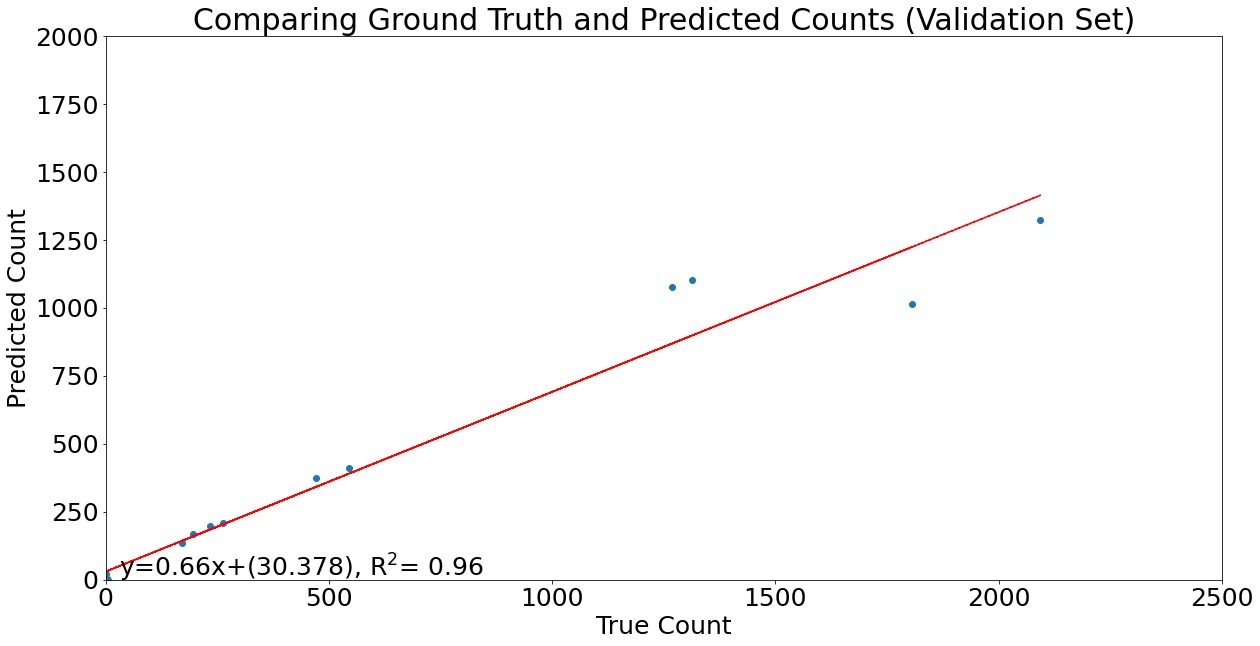

In [45]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams.update({'font.size': 25})
import pylab, scipy
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(xs,ys)

pylab.plot(xs,ys,'o')
z = np.polyfit(xs,ys,1)
p = np.poly1d(z)

plt.xlim(0,2500)
plt.ylim(0,2000)
plt.ylabel('Predicted Count')
plt.xlabel('True Count')
plt.title('Comparing Ground Truth and Predicted Counts (Validation Set)')
plt.text(30, 10, f"y={z[0]:.2f}x+({z[1]:.3f})," + " $\mathregular{R^{2}}$" + f"= {r_value**2:0.2f}")
pylab.plot(xs,p(xs),"r--")

# plt.savefig("newmodel_comparing_true_vs_predicted_counts.png")

In [25]:
def get_points_per_tile(tile_dict, points_dict, per_tile_count):
    for img_id, data in points_dict.items():
#         if img_id == 'DJI_20210928101833_0071.JPG':
#             import ipdb; ipdb.set_trace()
        points = []
        if data.get('Nesting'):
            points.extend(data['Nesting'])
        if data.get('Flying'):
            points.extend(data['Flying'])
        for point in points:
            x = point['x']
            y = point['y']
#             if x == 1125.8379147286312:
#                 import ipdb; ipdb.set_trace()
            tile_id = tl.get_tile_id_from_point(tile_dict, point)
            (t,b,l,r) = tile_dict[tile_id]
            tilename = (os.path.splitext(img_id)[0] + f"_t{t:04d}_b{b:04d}_l{l:04d}_r{r:04d}.jpg")
#         if tilename == 'DJI_20210928101833_0071_t3822_b4368_l1024_r1536.jpg':
#             import ipdb;ipdb.set_trace()
            per_tile_count[tilename] += 1
    return per_tile_count

In [26]:
all_results = {}
tile_results = {}
with open('../results/new-model/all-inference-results.json', 'r') as f:
    data = f.readlines()
    for datum in data:
        temp = json.loads(datum.replace('\n',''))
        img_id = temp['image'].split('_')[2]
        if all_results.get(img_id):
            all_results[img_id] += len(temp['prediction'])
        else:
            all_results[img_id] = len(temp['prediction'])
        img_id = temp['image']
        tile_results[img_id] = len(temp['prediction'])

In [27]:
per_tile_count = {}
for k, v in tile_results.items():
    per_tile_count[k] = 0
per_tile_count = get_points_per_tile(tile_dict, points_dict, per_tile_count)

In [32]:
xs = []
ys = []
for key, value in per_tile_count.items():
    img_id = os.path.splitext(key.split('_')[2])[0]
    xs.append(value)
    ys.append(tile_results[key])

In [90]:
len(ys)

30

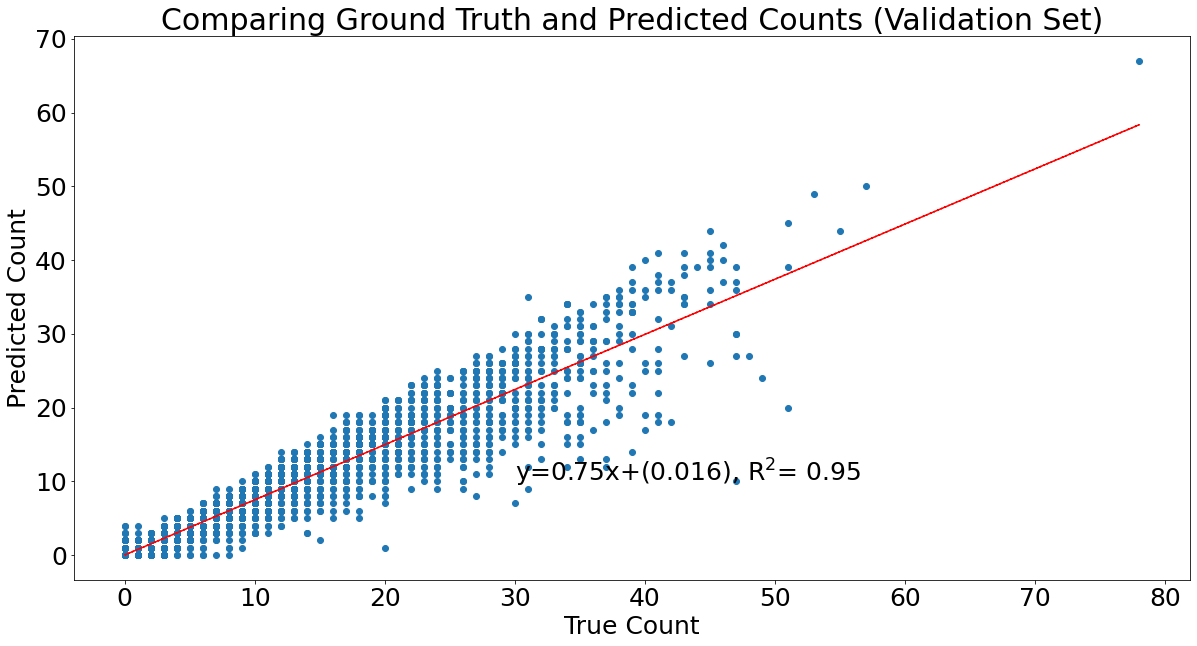

In [33]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams.update({'font.size': 25})
import pylab, scipy
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(xs,ys)

pylab.plot(xs,ys,'o')
z = np.polyfit(xs,ys,1)
p = np.poly1d(z)

# plt.xlim(0,2500)
# plt.ylim(0,2000)
plt.ylabel('Predicted Count')
plt.xlabel('True Count')
plt.title('Comparing Ground Truth and Predicted Counts (Validation Set)')
plt.text(30, 10, f"y={z[0]:.2f}x+({z[1]:.3f})," + " $\mathregular{R^{2}}$" + f"= {r_value**2:0.2f}")
pylab.plot(xs,p(xs),"r--")

plt.savefig("newmodel_comparing_true_vs_predicted_counts.png")

In [35]:
import pandas as pd

df = pd.read_csv("../per_image_count.csv", header=None)
gt_list = list(df[1].values)

truth = {}
for i in range(0,205):
    id = f"{(i+1):04d}"
    truth[id] = gt_list[i]

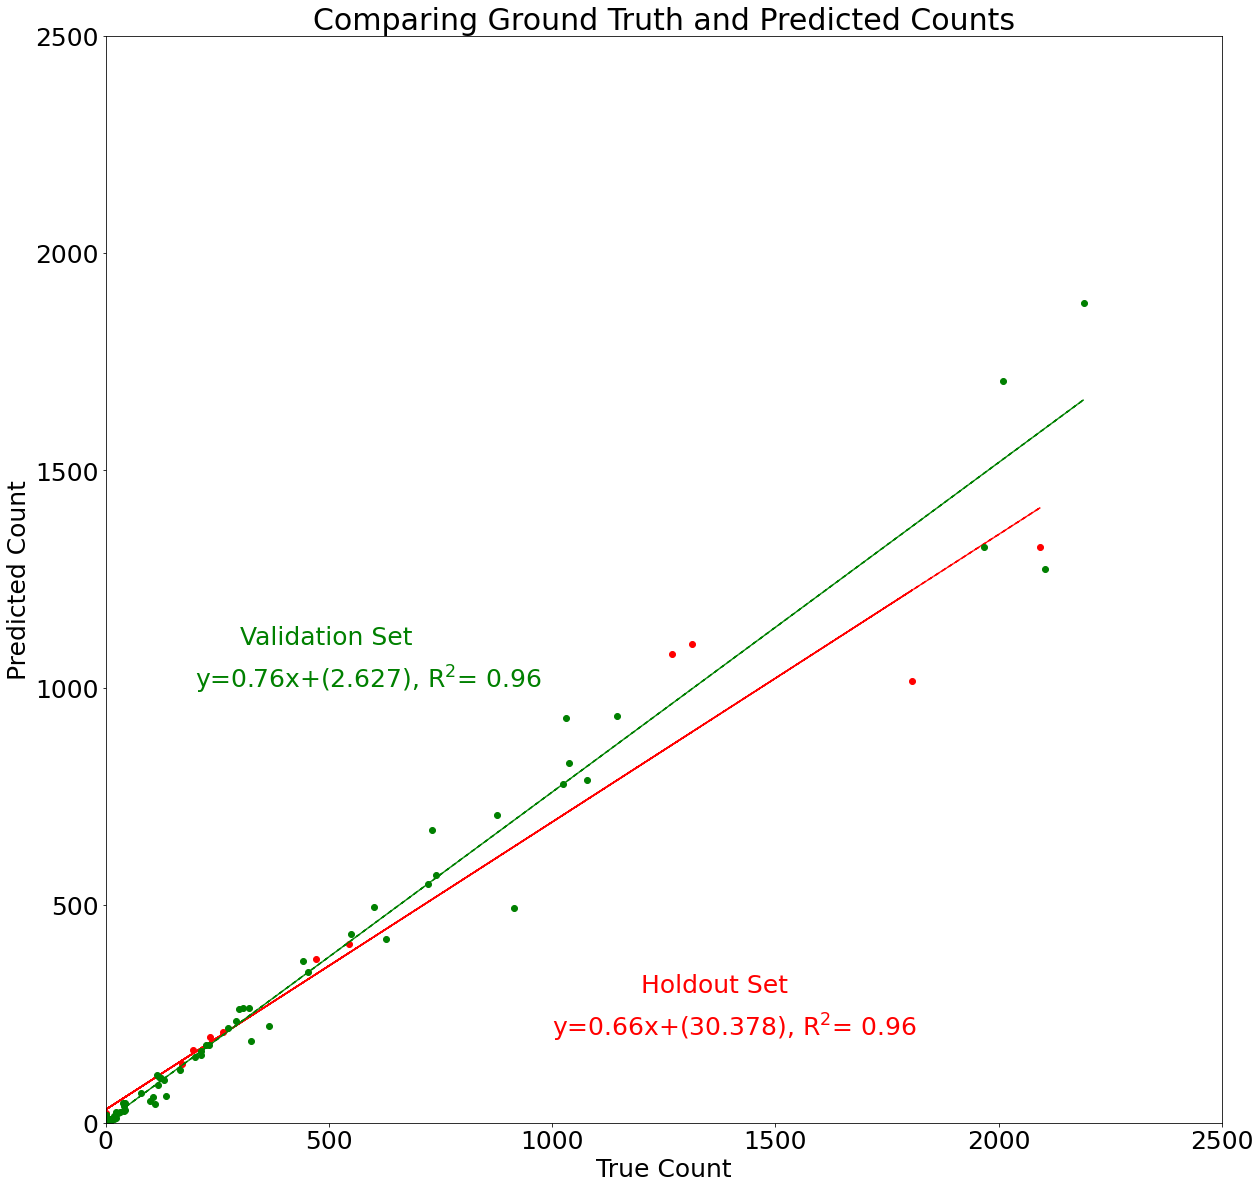

In [36]:
xs_h = []
ys_h = []
xs_t = []
ys_t = []
for k,v in all_results.items():
    if int(k) in hold_ids:
        xs_h.append(truth[k])
        ys_h.append(v)
    else:
        xs_t.append(truth[k])
        ys_t.append(v)

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,20)
plt.rcParams.update({'font.size': 25})
import pylab, scipy
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(xs_h,ys_h)

pylab.plot(xs_h,ys_h,'ro')
z_h = np.polyfit(xs_h,ys_h,1)
p_h = np.poly1d(z_h)

plt.xlim(0,2500)
plt.ylim(0,2500)
plt.ylabel('Predicted Count')
plt.xlabel('True Count')
plt.title('Comparing Ground Truth and Predicted Counts')
plt.text(1200, 300, f"Holdout Set", color='r')
plt.text(1000, 200, f"y={z_h[0]:.2f}x+({z_h[1]:.3f})," + " $\mathregular{R^{2}}$" + f"= {r_value**2:0.2f}", color='r')
pylab.plot(xs_h,p_h(xs_h),"r--")

pylab.plot(xs_t,ys_t,'go')
z_t = np.polyfit(xs_t,ys_t,1)
p_t = np.poly1d(z_t)

plt.xlim(0,2500)
plt.ylim(0,2500)
plt.text(300, 1100, "Validation Set", color='g')
plt.text(200, 1000, f"y={z_t[0]:.2f}x+({z_t[1]:.3f})," + " $\mathregular{R^{2}}$" + f"= {r_value**2:0.2f}", color='g')
pylab.plot(xs_t,p_t(xs_t),"g--")

plt.savefig("newmodel_comparing_true_vs_predicted_counts.png")

In [129]:
len(truth)

205

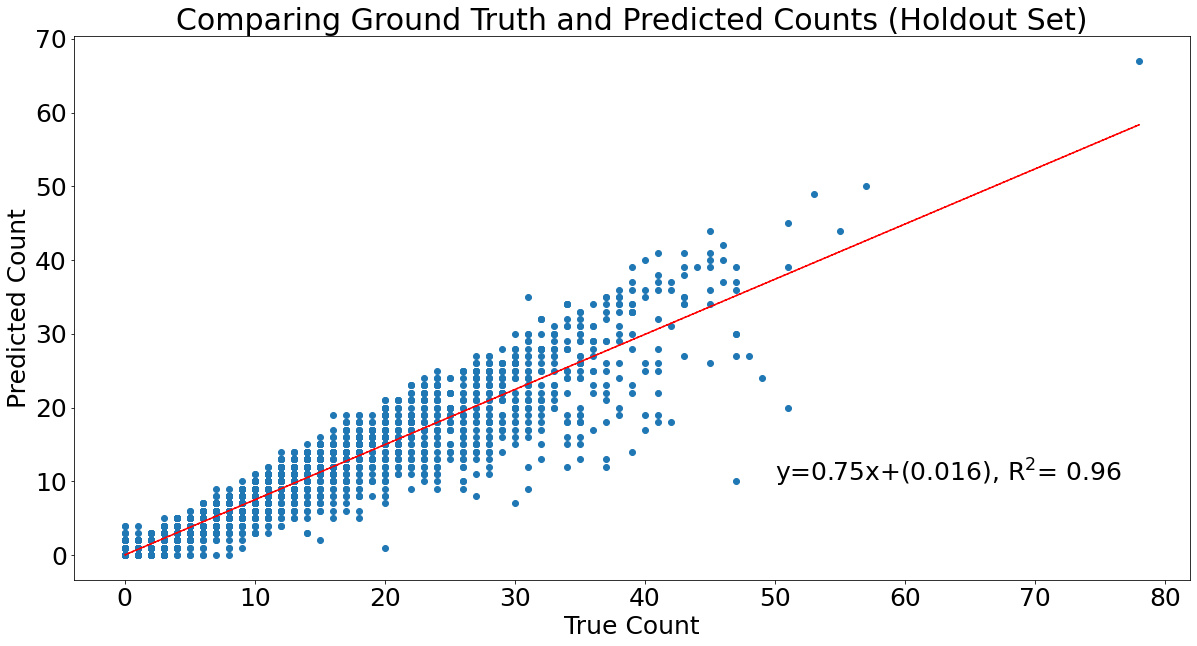

In [55]:
xt=[]
yt=[]
for k,v in tile_results.items():
    xt.append(per_tile_count[k])
    yt.append(v)
    
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams.update({'font.size': 25})
import pylab, scipy
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(xs,ys)

pylab.plot(xt,yt,'o')
z = np.polyfit(xt,yt,1)
p = np.poly1d(z)

# plt.xlim(0,2500)
# plt.ylim(0,2000)
plt.ylabel('Predicted Count')
plt.xlabel('True Count')
plt.title('Comparing Ground Truth and Predicted Counts (Holdout Set)')
plt.text(50, 10, f"y={z[0]:.2f}x+({z[1]:.3f})," + " $\mathregular{R^{2}}$" + f"= {r_value**2:0.2f}")
pylab.plot(xt,p(xt),"r--")

plt.savefig("newmodel_comparing_true_vs_predicted_counts.png")

In [17]:
testing = points_dict['DJI_20210928101833_0071.JPG']

In [28]:
c = 0
for label in testing:
    points = testing[label]
    for point in points:
        x = point['x']
        y = point['y']
        if 1024 <= x <= 1536 and 3822 <= y <= 4368:
#             print(x,y)
            c+=1

In [176]:
c

23

In [177]:
tile_results['DJI_20210928101833_0071_t3822_b4368_l1024_r1536.jpg']

22

In [48]:
for k,v in tile_results.items():
    if per_tile_count[k]==0 and v > 2:
        print(v)
        print(k)

4
DJI_20210928102047_0141_t2730_b3276_l6656_r7168.jpg
4
DJI_20210928102032_0133_t2730_b3276_l3072_r3584.jpg
3
DJI_20210928102032_0133_t1638_b2184_l4608_r5120.jpg
3
DJI_20210928101758_0053_t2730_b3276_l0512_r1024.jpg
3
DJI_20210928101748_0047_t4914_b5460_l3584_r4096.jpg


In [53]:
for k,v in tile_results.items():
    if v==0 and per_tile_count[k] > 7:
        print(per_tile_count[k])
        print(k)

8
DJI_20210928101720_0033_t1092_b1638_l7168_r7680.jpg
